In [1]:
using Turing
using DataFrames
using CSV
using Random
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using StatsPlots
using StatsBase
using FreqTables
using Logging

default(label=false)
Logging.disable_logging(Logging.Warn);

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1342
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatisticalRethinking [2d09df54-9d0f-5258-8220-54c2a3d4fbee]
└ @ Base loading.jl:1342
┌ Info: Precompiling StatisticalRethinkingPlots [e1a513d0-d9d9-49ff-a6dd-9d2e9db473da]
└ @ Base loading.jl:1342


# 12.1 Over-dispersed counts

Code 12.1

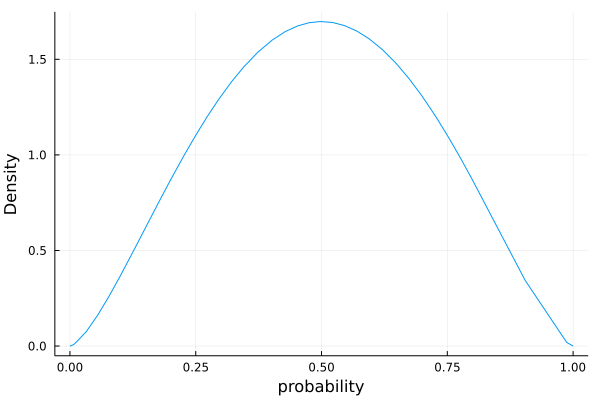

In [2]:
# define alias for Beta(α, β), see: https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size
Beta2(μ, ν) = Beta(μ*ν, (1-μ)*ν)
BetaBinomial2(n, μ, ν) = BetaBinomial(n, μ*ν, (1-μ)*ν)

p̄ = 0.5
θ = 5
plot(Beta2(p̄, θ), xlab="probability", ylab="Density")

Code 12.2

In [3]:
d = DataFrame(CSV.File("data/UCBadmit.csv", skipto=2, 
        header=[:id, :dept, :gender, :admit, :reject, :applications]))

d.gid = @. ifelse(d.gender == "male", 1, 2)

@model function m12_1(A, N, gid)
    a ~ MvNormal([0, 0], 1.5)
    p̄ = @. logistic(a[gid])
    ϕ ~ Exponential(1)
    θ = ϕ + 2
    @. A ~ BetaBinomial2(N, p̄, θ)
end

Random.seed!(1)
m12_1_ch = sample(m12_1(d.admit, d.applications, d.gid), NUTS(), 1000)
m12_1_df = DataFrame(m12_1_ch);

Code 12.3

In [4]:
m12_1_df.θ = m12_1_df.ϕ .+ 2
m12_1_df.da = m12_1_df."a[1]" .- m12_1_df."a[2]"
precis(m12_1_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.4218  0.3935  -1.0357  -0.4374  0.2071  ▁▁▂▄▆█▇▆▄▂▁▁▁▁ │
│  a[2] │  -0.326  0.4014  -0.9482  -0.3262  0.3537          ▁▁▅█▃▁ │
│     ϕ │  1.0505  0.8115   0.1089   0.8704  2.4536     ██▆▄▂▁▁▁▁▁▁ │
│     θ │  3.0505  0.8115   2.1089   2.8704  4.4536     ██▆▄▂▁▁▁▁▁▁ │
│    da │ -0.0958  0.5832   -0.994  -0.0992  0.8353       ▁▁▂▆██▄▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 12.4

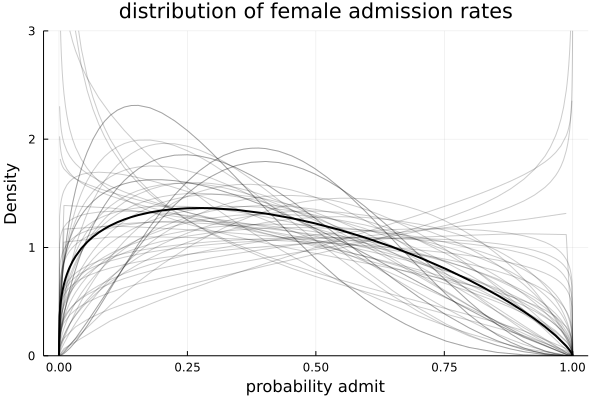

In [5]:
gid = 2
p̄ = m12_1_df[:, "a[$gid]"] .|> logistic |> mean
θ = mean(m12_1_df.θ)
plot(Beta2(p̄, θ), lw=2, c=:black, ylab="Density", 
    xlab="probability admit", ylims=(0, 3))

for (a, θ) ∈ first(zip(m12_1_df[:, "a[$gid]"], m12_1_df.θ), 50)
    plot!(Beta2(logistic(a), θ), c=:black, alpha=0.2)
end
gender = gid == 2 ? "female" : "male"
title!("distribution of $gender admission rates")

Code 12.5

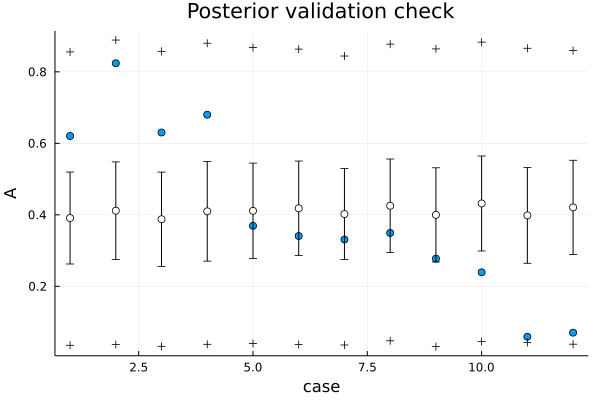

In [6]:
Random.seed!(1)

adm_rate = d.admit ./ d.applications

fun = (r, (N, gid)) -> begin
    p̄ = logistic(get(r, "a[$gid]", 0))
    rand(BetaBinomial2(N, p̄, r.θ))
end

pred_adm = link(m12_1_df, fun, zip(d.applications, d.gid))
pred_rates = pred_adm ./ d.applications

μ_adm = mean.(pred_rates)
σ = std.(pred_rates) ./ 2
ci_adm = PI.(pred_rates)

scatter(adm_rate, xlab="case", ylab="A", title="Posterior validation check")
scatter!(μ_adm, mc=:white, yerr=σ)
scatter!(first.(ci_adm), shape=:cross, c=:black)
scatter!(last.(ci_adm), shape=:cross, c=:black)

Code 12.6

In [7]:
d = DataFrame(CSV.File("data/Kline.csv"))
d.P = standardize(ZScoreTransform, log.(d.population))
d.contact_id = ifelse.(d.contact .== "high", 2, 1)

@model function m12_2(T, P, cid)
    g ~ Exponential()
    ϕ ~ Exponential()
    a ~ MvNormal([1,1], 1)
    b₁ ~ Exponential()
    b₂ ~ Exponential()
    b = [b₁, b₂]
    λ = @. exp(a[cid])*(P^b[cid]) / g
    p = 1/(ϕ+1)
    r = λ/ϕ
    clamp!(r, 0.01, Inf)
    p = clamp(p, 0.01, 1)
    @. T ~ NegativeBinomial(r, p)
end

Random.seed!(1)
m12_2_ch = sample(m12_2(d.total_tools, d.population, d.contact_id), NUTS(), 1000)
m12_2_df = DataFrame(m12_2_ch)
precis(m12_2_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%      histogram │
├───────┼────────────────────────────────────────────────────────┤
│  a[1] │ 0.8888  0.7358  -0.3216  0.8937  1.9908   ▁▁▁▁▃▆█▇▆▂▁▁ │
│  a[2] │ 1.0038  0.9476  -0.5036  1.0289  2.4515  ▁▁▁▂▄▆██▇▄▂▁▁ │
│    b₁ │ 0.2572  0.0485   0.1801  0.2571  0.3335       ▁▃▇█▃▁▁▁ │
│    b₂ │ 0.2749   0.122   0.0721  0.2746  0.4691        ▃▅██▃▁▁ │
│     g │ 1.1112  0.7524   0.2547  0.9492   2.577     ▅█▆▃▂▁▁▁▁▁ │
│     ϕ │ 1.2824  0.9127   0.1805  1.0914  2.9921        █▇▃▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────┘


# 12.2 Zero-inflated outcomes